<a href="https://colab.research.google.com/github/Rajeeb321123/Pytorch/blob/master/05_transfer_learning_in_pytorch_part2_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install kaggle

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


'cuda'

In [3]:
# Are we using a GPU?
!nvidia-smi

Wed Feb 19 01:27:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data

In [4]:
import os

# Set Kaggle API credentials
os.environ["KAGGLE_USERNAME"] = "rajeepthapa"
os.environ["KAGGLE_KEY"] = "55ba83ad31890ca94883d150a3f68903"

In [5]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 97% 84.0M/86.8M [00:05<00:00, 22.8MB/s]
100% 86.8M/86.8M [00:05<00:00, 17.4MB/s]


In [6]:
import zipfile
import os

# Path to the zip file
zip_file_path = "/content/brain-tumor-classification-mri.zip"

# Path to the extraction directory
extract_dir = "/content/brain-tumor-classification-mri"

# Create the extraction directory if it does not exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file into the specified directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to {extract_dir}")


Extracted files to /content/brain-tumor-classification-mri


In [7]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/brain-tumor-classification-mri"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")##

There are 2 directories and 0 images in '/content/brain-tumor-classification-mri'.
There are 4 directories and 0 images in '/content/brain-tumor-classification-mri/Training'.
There are 0 directories and 827 images in '/content/brain-tumor-classification-mri/Training/pituitary_tumor'.
There are 0 directories and 826 images in '/content/brain-tumor-classification-mri/Training/glioma_tumor'.
There are 0 directories and 822 images in '/content/brain-tumor-classification-mri/Training/meningioma_tumor'.
There are 0 directories and 395 images in '/content/brain-tumor-classification-mri/Training/no_tumor'.
There are 4 directories and 0 images in '/content/brain-tumor-classification-mri/Testing'.
There are 0 directories and 74 images in '/content/brain-tumor-classification-mri/Testing/pituitary_tumor'.
There are 0 directories and 100 images in '/content/brain-tumor-classification-mri/Testing/glioma_tumor'.
There are 0 directories and 115 images in '/content/brain-tumor-classification-mri/Testin

In [8]:
def count_images(folder):
    count = 0
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            count += len(os.listdir(subdir_path))
    return count

train_dir = "/content/brain-tumor-classification-mri/Training/"
test_dir = "/content/brain-tumor-classification-mri/Testing/"

print(f"Total Train Images: {count_images(train_dir)}")
print(f"Total Test Images: {count_images(test_dir)}")

Total Train Images: 2870
Total Test Images: 394


In [9]:
# Let's get the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [10]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# to select image randomly image
def view_random_image(target_dir, target_class): #target_dir in directory, target_class is either steak or pizza here
  # Setup the target directory (we'll view iamges from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder  + "/" + random_image[0]) # we random_image in list format so, we change into string path format to read
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape:{img.shape}") # show the shape of the image

  return img

['image(51).jpg']
Image shape:(226, 233, 3)


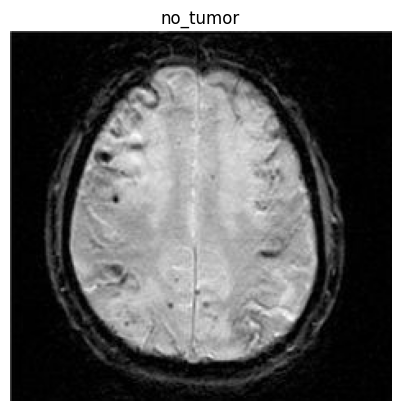

In [11]:
# Visualize, Visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

# Augmentation and Batch Creation

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


torch.manual_seed(42)
BATCH_SIZE = 32


# Define transformations for the validation sets
transform_without_augmentation = transforms.Compose([
    transforms.Resize((224, 224)), # resize every image to 64
    transforms.ToTensor(),
])

# Define the transformation for the transform_
transform_with_augmentation =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(
        degrees=20,              # randomly rotate images by -20 to 20 degrees
        translate=(0.2, 0.3),    # randomly shift images: 20% horizontally, 30% vertically
        scale=(0.8, 1.2),        # randomly zoom images: scale ranges from 80% to 120%
        shear=20               # randomly shear images by -20 to 20 degrees
    ),
    transforms.RandomHorizontalFlip(),
    ## above and below are same
    # transforms.RandomRotation(degrees=20),  # Rotates randomly within ±20 degrees
    # transforms.RandomAffine(degrees=0, shear=20),  # Shear transformation
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),  # Zoom effect
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    # transforms.RandomAffine(degrees=0, translate=(0.2, 0.3)),  # Width and height shift
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the datasets with the transformations
train_data = datasets.ImageFolder(root=train_dir, transform=transform_with_augmentation)
valid_data = datasets.ImageFolder(root=test_dir, transform=transform_without_augmentation)

# for the demonstration only in plot. We always augmented
train_data_without_augmented = datasets.ImageFolder(root=train_dir, transform=transform_without_augmentation)

print(f"The total train_data is :{len(train_data)}")
print(f"The total test_data is :{len(valid_data)}")

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

# for demonsatration only in plot
train_dataloader_without_augmented = DataLoader(train_data_without_augmented, batch_size=BATCH_SIZE, shuffle=False)
train_dataLoader_unsuffled = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"The classes are: {train_data.classes}")

The total train_data is :2870
The total test_data is :394
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7eeda0ab5b50>, <torch.utils.data.dataloader.DataLoader object at 0x7eeda0a94c10>)
Length of train dataloader: 90 batches of 32
Length of test dataloader: 13 batches of 32
The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [13]:
for each_batch in list(train_dataloader)[-4:]:
  print(each_batch[0].shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([22, 3, 224, 224])


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
showing image number:1


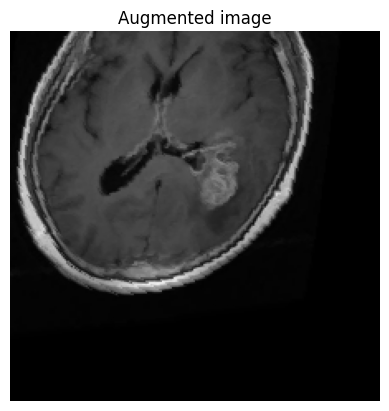

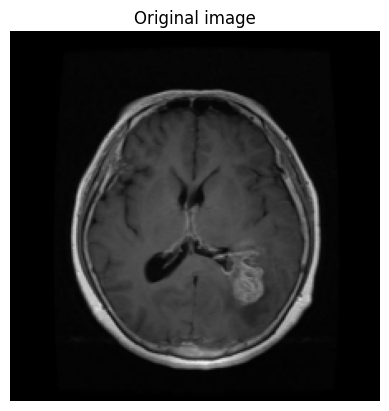

In [14]:
# Get a batch of data
# When you use next(iter(train_dataloader)), it retrieves the next batch of data from the DataLoader iterator, not specifically the last batch. It fetches batches one by one from the beginning of the DataLoader each time it is invoked until there are no more batches left.
# Get sample data batches (last batch)
images, labels = next(iter(train_dataLoader_unsuffled))


print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")


unaugmented_images, unagmented_labels = next(iter(train_dataloader_without_augmented))

# Show original image and augmented image
import random
random_number = random.randint(0, 32) # our batch size are 32... so random from 0 to 32
print(f"showing image number:{random_number}")
plt.title(f"Augmented image")
plt.imshow(images[random_number].permute(1, 2, 0) ) # we need to do permute for making 224 x 224 x 3
plt.axis(False)
plt.figure()
plt.title(f"Original image")
plt.imshow(unaugmented_images[random_number].permute(1, 2, 0) )
plt.axis(False);

# Download Pretrained model

In [15]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [47]:
import torchvision.models as models
from torchvision import transforms

def create_base_model(model_url, model_name):
    """
    Loads a pretrained model from PyTorch Hub and modifies its classifier to match num_classes.

    Args:
      model_url (str): PyTorch Hub repository string, e.g. "pytorch/vision:v0.10.0"
      model_name (str): The name of the model to load, e.g. "resnet18"
      num_classes (int): Number of output classes. Default is 10.

    Returns:
      model (nn.Module): Modified model with a frozen feature extractor and a new classification layer.
    """

    # Load a pretrained model
    # Load the pretrained model from PyTorch Hub.
    base_model = torch.hub.load(model_url, model_name, pretrained=True)

    # Remove the classification head by replacing it with an identity mapping.
    base_model.classifier = nn.Identity()

    # Freeze feature extractor layers
    for param in base_model.parameters():
      param.requires_grad = False

    # EfficientNetB0 (as implemented in PyTorch via Torch Hub or torchvision) already includes an adaptive average pooling layer (specifically, nn.AdaptiveAvgPool2d).
    # This layer is applied in the forward pass to ensure that the spatial dimensions are pooled to a fixed size (usually 1x1) before flattening and passing the features to the classifier.

    return base_model


base_model_url = "pytorch/vision"
base_model_name = "efficientnet_b0"
base_model = create_base_model(base_model_url, base_model_name)

# To see the model summary:
print(base_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
# Count all submodules (including the top-level model itself)
total_modules = len(list(base_model.modules()))
print("Total modules in model:", total_modules)

# All layers:
total_layers = len(list(base_model.features.children()))
print("Total layers in model:", total_layers)

Total modules in model: 335
Total layers in model: 9


In [49]:
import torch
import torch.nn as nn

# PyTorch example
x = torch.randn(1, 3, 224, 224)  # The tensor dimensions are [batch_size, channels, height, width]
# pool = nn.AdaptiveAvgPool2d(output_size=1)
# x = pool(x)
# x = x.view(x.size(0), -1)  # Flatten the tensor
x = base_model(x)
print(x.shape)


torch.Size([1, 1280])


In [50]:
class CustomModel(nn.Module):
    def __init__(self, base_model, num_classes=10):
        super(CustomModel, self).__init__()
        self.base = base_model

        # EfficientNetB0 (as implemented in PyTorch via Torch Hub or torchvision) already includes an adaptive average pooling layer (specifically, nn.AdaptiveAvgPool2d).
        # This layer is applied in the forward pass to ensure that the spatial dimensions are pooled to a fixed size (usually 1x1) before flattening and passing the features to the classifier.

        self.dropout = nn.Dropout(p=0.2, inplace=True) # inplace just to save memory.
        # The base model outputs a 1280-dimensional feature vector.
        self.classifier = nn.Linear(1280, num_classes, bias=True)

    def forward(self, x):

        # if you have frozen all efficientb0 layers
        # # running the backbone in inference mode so that batch normalization layers don't update),
        # # force the base model to evaluation mode and disable gradient computation.
        # self.base.eval()
        # with torch.no_grad():
        #     x = self.base(x)  # x now has shape [batch_size, 1280]

        x = self.base(x)
        # Pass the extracted features through the custom classification head.
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# -------------------------------
# 3. Instantiate and test the model.
# -------------------------------
model = CustomModel(base_model, num_classes=10)

In [51]:
%%capture
!pip install torchinfo
# Print a summary using torchinfo (uncomment for actual output)


In [52]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
CustomModel (CustomModel)                                         [32, 3, 224, 224]    [32, 10]             --                   Partial
├─EfficientNet (base)                                             [32, 3, 224, 224]    [32, 1280]           --                   False
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]   [32, 24, 56, 56]     (16,714)             False
│    │    └─Sequential (3)                       

In [53]:
# Initialize a counter
layer_count = 0


# Iterate through the model's named children and print each layer's name and class
for name, layer in model.named_children():
    print(f"Layer {layer_count + 1}: {name} - {layer.__class__.__name__}")
    layer_count += 1

print(f"\nThe model has {layer_count} layers.\n\n\n")

learnable_layers_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        learnable_layers_count += 1
print(f"The model has {learnable_layers_count} learnable layers.")

Layer 1: base - EfficientNet
Layer 2: dropout - Dropout
Layer 3: classifier - Linear

The model has 3 layers.



classifier.weight torch.Size([10, 1280])
classifier.bias torch.Size([10])
The model has 2 learnable layers.


In [54]:
base_block = model.base.features
trainable_params = [p for p in base_block.parameters() if p.requires_grad]
print("Trainable parameters in base block:", len(trainable_params))

Trainable parameters in base block: 0


## Unfreeze the last 10 modules

In [55]:
feature_layers = list(base_model.features.children())
print("Total submodules in base_model.features:", len(feature_layers))

# base_children = list(model.base.features.children())

# # Check that we have enough layers to freeze (if not, adjust as needed)
# if len(base_children) < 3:
#     print("Warning: The base model has fewer than 10 submodules; nothing to unfreeze.")
# else:
#     # Freeze all layers except the last 10 submodules.
#     for layer in base_children[-10:]:
#         for param in layer.parameters():
#             param.requires_grad = True


Total submodules in base_model.features: 9


In [56]:
base_all_submodules = list(model.base.modules())
print("Total submodules (including nested ones):", len(base_all_submodules))


# Check that we have enough layers to freeze (if not, adjust as needed)
if len(base_all_submodules) < 10:
    print("Warning: The base model has fewer than 10 submodules; nothing to unfreeze.")
else:
    # unFreeze all layers except the last 10 submodules.
    for module in base_all_submodules[-20:]:
        for param in module.parameters():
            param.requires_grad = True


Total submodules (including nested ones): 335


In [57]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
CustomModel (CustomModel)                                         [32, 3, 224, 224]    [32, 10]             --                   Partial
├─EfficientNet (base)                                             [32, 3, 224, 224]    [32, 1280]           --                   Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]   [32, 24, 56, 56]     (16,714)             False
│    │    └─Sequential (3)                   

In [58]:
# Sum up all trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_trainable_params)

# Sum up all nontrainable parameters
total_nontrainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad==False)
print("Total non-trainable parameters:", total_nontrainable_params)

Total trainable parameters: 918714
Total non-trainable parameters: 3101644


# Compile, Train

In [59]:
initial_lr = 1e-3
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                      lr=0.001,              # equivalent to learning_rate=0.001
                      betas=(0.9, 0.999),    # equivalent to beta_1=0.9 and beta_2=0.999
                      eps=1e-07,             # equivalent to epsilon=1e-07
                      amsgrad=False,         # equivalent to amsgrad=False
                      weight_decay=0.0       # if you don't need weight decay, set to 0.0; otherwise, use your desired value)
)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
lr_lambda = lambda epoch: 1 if epoch< 40 else 0.95  **  epoch
# lr = 1e-3 * 10**(epoch/10)
# In PyTorch, since optimizer's lr is already initial_lr, we set:
# lr_factor(epoch) = 10**(epoch/10)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [60]:
images, labels = next(iter(valid_dataloader))

# Make predictions
model.eval()
with torch.inference_mode():
    images = images.to(device)
    y_logits = model(images)[:5]

print(y_logits)
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(torch.sum(y_pred_probs[3,:]))

_, x = torch.max(y_logits, 1)
print(x)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:5]}\nLabels: {labels[:5]}")

tensor([[ 0.2363,  0.1853,  0.0200, -0.0121,  0.2786, -0.0945, -0.0770,  0.3503,
          0.1410, -0.2072],
        [ 0.1364,  0.2379,  0.2669, -0.3014,  0.0687, -0.3949, -0.1582,  0.2536,
          0.2663,  0.1274],
        [-0.0132,  0.3077, -0.1073, -0.1898, -0.0153, -0.3078,  0.0745,  0.4171,
          0.2551,  0.1129],
        [ 0.1513,  0.3100, -0.0490, -0.2212,  0.0790, -0.2437,  0.0931,  0.2791,
          0.3443, -0.1270],
        [ 0.1513,  0.3100, -0.0490, -0.2212,  0.0790, -0.2437,  0.0931,  0.2791,
          0.3443, -0.1270]], device='cuda:0')
tensor(1., device='cuda:0')
tensor([7, 2, 7, 8, 8], device='cuda:0')
Predictions: tensor([7, 2, 7, 8, 8], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0])


Epoch 1/20 | LR: 0.001000 | Train Loss: 64.9158, Train Acc: 76.8641 | Val Loss: 202.0300, Val Acc: 50.5076
Epoch 2/20 | LR: 0.001000 | Train Loss: 42.2020, Train Acc: 83.9024 | Val Loss: 183.4963, Val Acc: 58.8832
Epoch 3/20 | LR: 0.001000 | Train Loss: 37.1763, Train Acc: 85.9582 | Val Loss: 180.3831, Val Acc: 56.8528
Epoch 4/20 | LR: 0.001000 | Train Loss: 34.0298, Train Acc: 86.8293 | Val Loss: 210.5324, Val Acc: 57.1066
Epoch 5/20 | LR: 0.001000 | Train Loss: 32.5996, Train Acc: 86.6899 | Val Loss: 173.5756, Val Acc: 56.0914
Epoch 6/20 | LR: 0.001000 | Train Loss: 29.8778, Train Acc: 88.5714 | Val Loss: 172.2907, Val Acc: 62.9442
Epoch 7/20 | LR: 0.001000 | Train Loss: 28.4257, Train Acc: 88.9547 | Val Loss: 199.8051, Val Acc: 60.9137
Epoch 8/20 | LR: 0.001000 | Train Loss: 25.9924, Train Acc: 90.2091 | Val Loss: 181.2599, Val Acc: 63.7056
Epoch 9/20 | LR: 0.001000 | Train Loss: 24.4011, Train Acc: 90.2439 | Val Loss: 188.8238, Val Acc: 63.7056
Epoch 10/20 | LR: 0.001000 | Train Lo

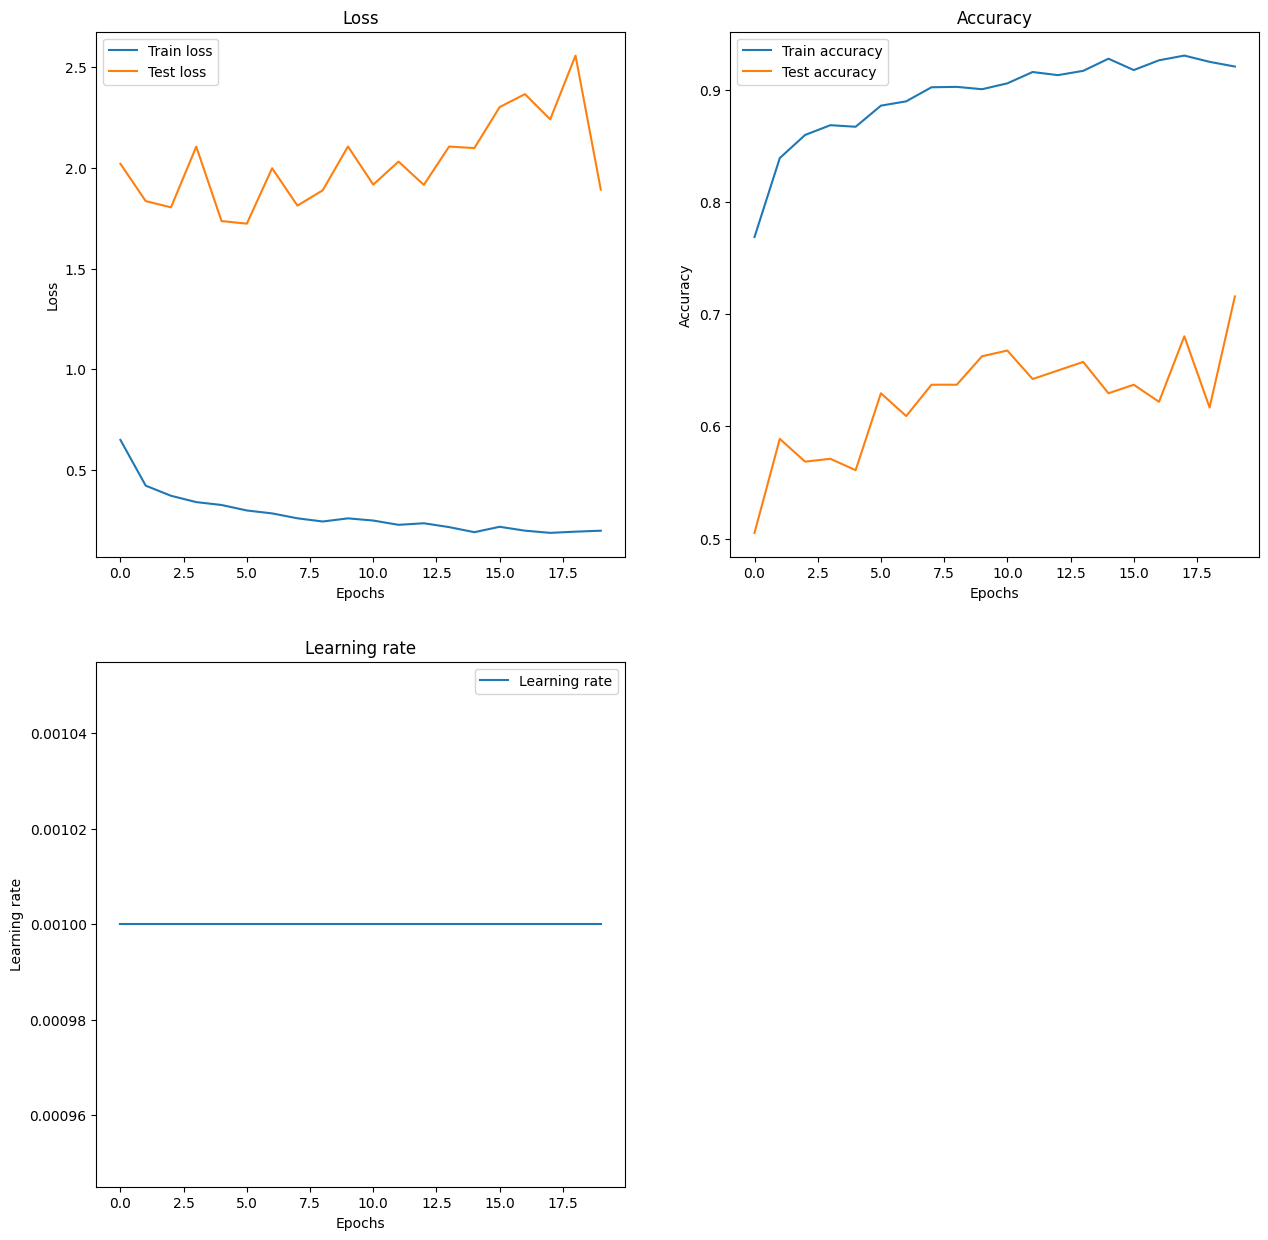

In [61]:
# fit or train loop
torch.manual_seed(42)
epochs = 20

train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []
epoch_count = []
learning_rate = []

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_correct = 0
    total = 0
    #
    # y_pred_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # loss = loss_fn(y_logits, y_train) # we use y_logits here because CrossEntropyloss uses softmax internally. os we need raw model output
    # acc = accuracy_fn(y_true=y_train,
    #                   y_pred=y_pred_probs)

    for inputs, labels in train_dataloader:
      # Move inputs and labels to the device
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      y_logits = model(inputs)
      loss = loss_fn(y_logits, labels) # no need for softmax crosentropy does it internally.
      loss.backward()
      optimizer.step()
      # Statistics
      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(y_logits, 1) #ignore the value. just focus on indices i.e preds
      running_correct += (preds == labels).sum().item()
      total += labels.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    ### Testing
      # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss/ val_total
    val_acc = val_correct / val_total

    # Print out what's happening
    current_lr = scheduler.get_last_lr()[0]
    learning_rate.append(current_lr)

    if epoch % 1 == 0 or epoch + 1 == epochs:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(val_loss)
        train_acc_values.append(train_acc)
        test_acc_values.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} | "
        f"LR: {current_lr:.6f} | "
        f"Train Loss: {(100*train_loss):.4f}, Train Acc: {(100*train_acc):.4f} | "
        f"Val Loss: {(100*val_loss):.4f}, Val Acc: {(100*val_acc):.4f}")
    # Step the scheduler at the end of the epoch
    scheduler.step()



# Plot
plt.figure(figsize=(15, 15))
ax_1 = plt.subplot(2, 2, 1)
ax_2 = plt.subplot(2, 2, 2)
ax_3 = plt.subplot(2, 2, 3)
ax_1.plot(epoch_count,
         train_loss_values,
         label="Train loss")
ax_1.plot(epoch_count,
         test_loss_values,
         label="Test loss")
ax_2.plot(epoch_count,
         train_acc_values,
         label="Train accuracy")
ax_2.plot(epoch_count,
         test_acc_values,
         label="Test accuracy")
ax_3.plot(epoch_count,
         learning_rate,
         label="Learning rate")
ax_1.legend()
ax_2.legend()
ax_3.legend()

ax_1.set_xlabel("Epochs")
ax_2.set_xlabel("Epochs")
ax_3.set_xlabel("Epochs")

ax_1.set_ylabel("Loss")
ax_2.set_ylabel("Accuracy")
ax_3.set_ylabel("Learning rate")

ax_1.set_title("Loss")
ax_2.set_title("Accuracy")
ax_3.set_title("Learning rate")
plt.legend();

In [62]:
# Note: the confusion matrix code we're about to write is a remix of scikit-learn's plot_confusion_matrix
# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):

  # Create the confusion matrix
  cm = confusion_matrix(y_true,y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] #normalize our confusion matrix

  n_classes = cm.shape[0]

  # Let's prettify it


  fig, ax = plt.subplots(figsize = figsize)

  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


# Set labels to the classes
  if classes is not None:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])  # setting labels 0 t0 1, as shape[0] is 2

  # Labels the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel = "True label",
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
        )

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Rotate x-axis labels
  plt.xticks(rotation=45)

  # Adjust the labels size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for direction colors
  threshold = (cm.max() + cm.min()) /2.  # give different shades of color respective to how many values are in each box , darker for more value

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size
            )
  plt.tight_layout()

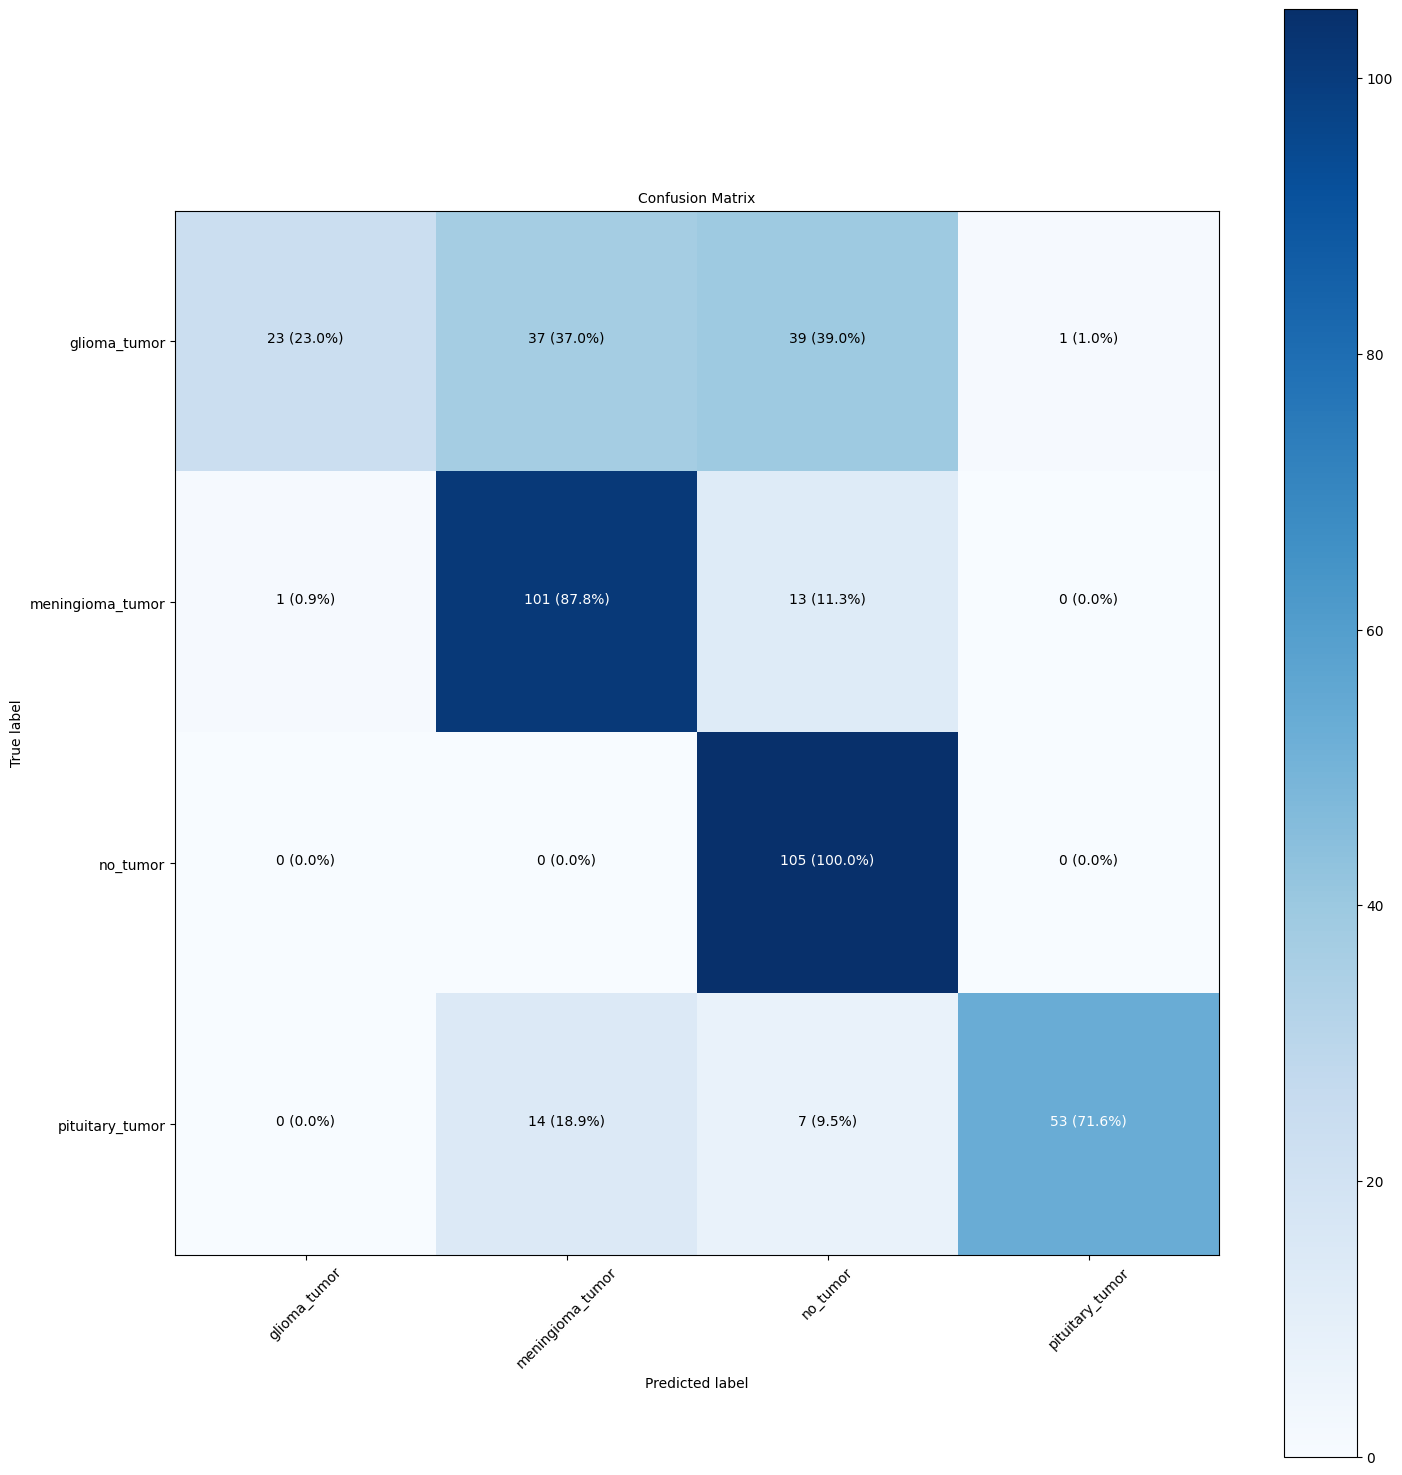

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Validation phase
model.eval()
with torch.no_grad():
    for inputs, labels in valid_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
# cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
make_confusion_matrix(all_labels,all_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10
                      )

### Prediction

In [64]:


# Define transformations for the validation sets
transform_without_augmentation = transforms.Compose([
    transforms.Resize((224, 224)), # resize every image to 64
    transforms.ToTensor(),
])


# Create a function to import an image and resize it to be able to used with our
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, converts it to a tensor, and resizes it to (img_shape, img_shape).
    """
    # Open the image file
    img = Image.open(filename)  # Convert to grayscale for MNIST-like input

    img = transform_without_augmentation(img)


    # Add batch dimension
    img = img.unsqueeze(0)

    return img

In [65]:
def pred_and_plot(model, filename, class_names=class_names, real_class_name=''):
  """
  Import an image located at filename, makes a prediciton with model
  and plot the images with the predicted class as teh title.
  """
  # Import the target iamge and preprocess it
  img = load_and_prep_image(filename)

  model.eval()
  with torch.no_grad():
    image = img.to(device)
    y_logits = model(image)
    # Turn predicted logits in prediction probabilities
    y_pred_probs = torch.softmax(y_logits, dim=1)
    # Turn prediction probabilities into prediction labels
    y_pred = y_pred_probs.argmax(dim=1)
    print("y_pred:", y_pred)


  # Plot the image and predict class
  # plt.imshow(img.squeeze().permute(1,2,0))
  # Path to your image
  image_path = filename
  # Load the image using PIL
  image = Image.open(image_path)
  # Display the image
  plt.imshow(image)
  plt.title(f"Prediction: {class_names[int(y_pred.cpu().numpy().item())]}, Real class: {real_class_name}")
  plt.axis(False);

  plt.axis(False);

y_pred: tensor([3], device='cuda:0')


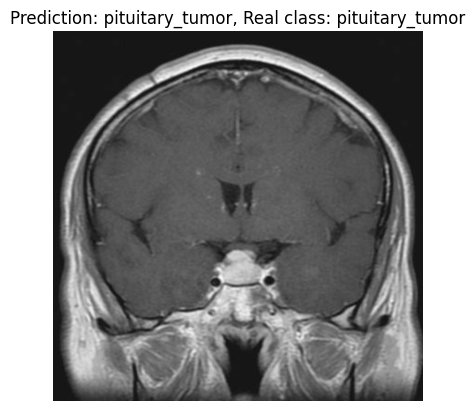

In [69]:
pred_and_plot(model, "/content/brain-tumor-classification-mri/Testing/pituitary_tumor/image(10).jpg", class_names=class_names, real_class_name="pituitary_tumor")